In [19]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import gcm_filtering
import os

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

importlib.reload(gcm_filtering)
from gcm_filtering import filter_inputs
from gcm_filtering import filter_inputs_dataset

import aerobulk
from aerobulk import noskin

The methodology we are following for these partial filtering tests is included here
![Methodology](IMG_2792.png)

In [3]:
from distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=4, threads_per_worker=2)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/panalluri/proxy/8787/status,
Dashboard: /user/panalluri/proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43179,Workers: 4
Dashboard: /user/panalluri/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:34415,Total threads: 2
Dashboard: /user/panalluri/proxy/40131/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:46475,


In [10]:
ds_HR = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_20Yrs.zarr", engine="zarr", chunks={}
) 
ds_HR = ds_HR.isel(xt_ocean=slice(700,1500), yt_ocean=slice(1250, 1750))
ds_HR

<xarray.Dataset>
Dimensions:       (yt_ocean: 500, xt_ocean: 800, time: 731)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-27 12:00:00
    wet           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
  * xt_ocean      (xt_ocean) float64 -209.9 -209.8 -209.7 ... -130.2 -130.1
  * yt_ocean      (yt_ocean) float64 0.55 0.65 0.75 0.85 ... 44.82 44.89 44.97
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 500, 800), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 500, 800), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 500, 800), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 500, 800), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 500, 800), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 500, 800), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 500, 800), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 500, 800), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 500, 800), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 500, 800), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 500, 800), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 500, 800), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [11]:
ds_LR = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_LR_southAtlantic_every10TimeSteps_20Yrs.zarr", engine="zarr", chunks={}
) 
ds_LR = ds_LR.isel(xt_ocean=slice(700,1500), yt_ocean=slice(1250, 1750))
ds_LR

<xarray.Dataset>
Dimensions:       (time: 731, yt_ocean: 500, xt_ocean: 800)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-27 12:00:00
  * xt_ocean      (xt_ocean) float64 -209.9 -209.8 -209.7 ... -130.2 -130.1
  * yt_ocean      (yt_ocean) float64 0.55 0.65 0.75 0.85 ... 44.82 44.89 44.97
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 500, 800), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 500, 800), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 500, 800), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 500, 800), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 500, 800), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 500, 800), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

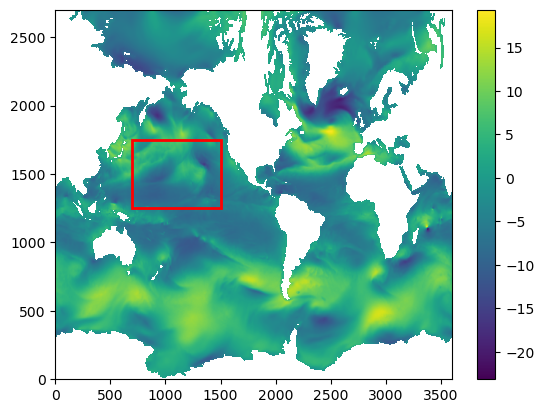

In [7]:
# Extract the data for the specific region
data = ds_in.u_ref.isel(time=0)

# Plot the data using pcolor
plt.pcolor(data, cmap='viridis')

# Get the bounds of the region (using the indices)
x_min, x_max = 700, 1500
y_min, y_max = 1250, 1750

# Draw a rectangle around the region (the coordinates are based on the index positions)
rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='red', facecolor='none')
plt.gca().add_patch(rect)  # Add the rectangle to the current axes

# Show the plot
plt.colorbar()
plt.show()


In [12]:
heatfluxHR = xr.open_dataset(
    "gs://leap-persistent/panalluri/HF_highRes.zarr", engine="zarr", chunks={}
)
heatfluxHR = heatfluxHR.isel(xt_ocean=slice(700,1500), yt_ocean=slice(1250, 1750))
heatfluxHR

<xarray.Dataset>
Dimensions:                        (time: 365, yt_ocean: 500, xt_ocean: 800)
Coordinates:
  * time                           (time) object 0181-01-01 12:00:00 ... 0181...
  * xt_ocean                       (xt_ocean) float64 -209.9 -209.8 ... -130.1
  * yt_ocean                       (yt_ocean) float64 0.55 0.65 ... 44.89 44.97
Data variables:
    __xarray_dataarray_variable__  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 500, 800), meta=np.ndarray>

In [25]:
print("Filtering model")
ds_HFHR_50 = filter_inputs_dataset(heatfluxHR, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')
ds_HFHR_50

Filtering model


<xarray.Dataset>
Dimensions:                        (time: 365, xt_ocean: 800, yt_ocean: 500)
Coordinates:
  * time                           (time) object 0181-01-01 12:00:00 ... 0181...
  * xt_ocean                       (xt_ocean) float64 -209.9 -209.8 ... -130.1
  * yt_ocean                       (yt_ocean) float64 0.55 0.65 ... 44.89 44.97
Data variables:
    __xarray_dataarray_variable__  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 500, 800), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

In [15]:
data = ds_LR.isel(time=0)

ql, qh, taux, tauy, evap =  noskin(
        data.surface_temp,
        data.t_ref,
        data.q_ref,
        data.u_relative,
        data.v_relative,
        slp=data.slp,
        algo='ecmwf',
        zt=2,
        zu=10,
)

HF_LR_base = qh + ql
HF_LR_base

<xarray.DataArray (yt_ocean: 500, xt_ocean: 800)>
dask.array<add, shape=(500, 800), dtype=float32, chunksize=(500, 800), chunktype=numpy.ndarray>
Coordinates:
    time      object 0181-01-01 12:00:00
  * xt_ocean  (xt_ocean) float64 -209.9 -209.8 -209.7 ... -130.3 -130.2 -130.1
  * yt_ocean  (yt_ocean) float64 0.55 0.65 0.75 0.85 ... 44.75 44.82 44.89 44.97

In [26]:
# Wrap LR HF into a Dataset
da = xr.DataArray(
    HF_LR_base, 
    dims=['yt_ocean', 'xt_ocean'],
    coords={'yt_ocean': HF_LR_base.yt_ocean, 'xt_ocean': HF_LR_base.xt_ocean},
    name='variable'
)
ds = xr.Dataset({'variable': HF_LR_base})

# Filter it to smooth it out
print("Filtering model")
ds_HFLR_50 = filter_inputs_dataset(ds, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')
ds_HFLR_50

Filtering model


<xarray.Dataset>
Dimensions:   (xt_ocean: 800, yt_ocean: 500)
Coordinates:
    time      object 0181-01-01 12:00:00
  * xt_ocean  (xt_ocean) float64 -209.9 -209.8 -209.7 ... -130.3 -130.2 -130.1
  * yt_ocean  (yt_ocean) float64 0.55 0.65 0.75 0.85 ... 44.75 44.82 44.89 44.97
Data variables:
    variable  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

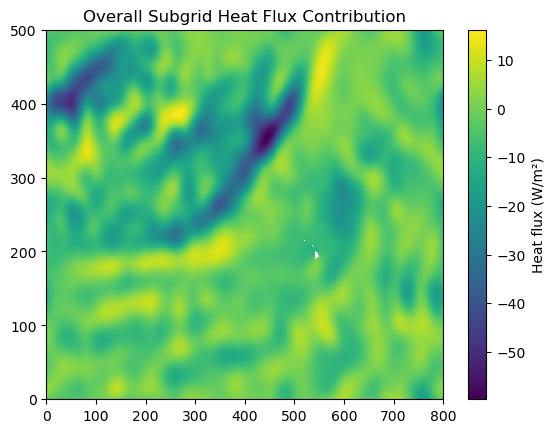

In [74]:
snapshot_HFHR = ds_HFHR_50.isel(time=0)
snapshot_HFLR = ds_HFLR_50['variable']
snapshot_HFSGS = snapshot_HFHR - snapshot_HFLR
im = plt.pcolor(snapshot_HFSGS['__xarray_dataarray_variable__'])
plt.title("Overall Subgrid Heat Flux Contribution")
plt.colorbar(im, label="Heat flux (W/m²)")
plt.show()

# Case 1: Filter only atmospheric vars

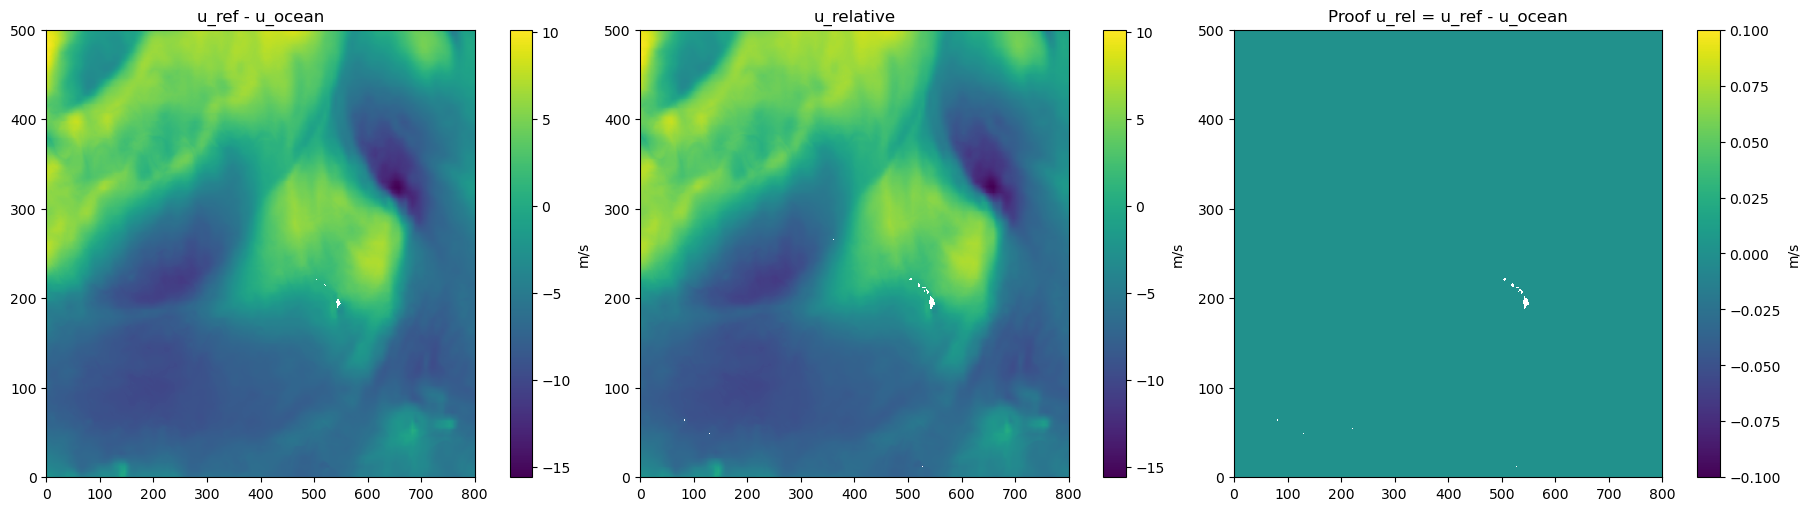

In [58]:
# Sign convention check

fig, axes = plt.subplots(ncols=3, figsize=(18, 5), constrained_layout=True)

# Plot 1
data_1 = ds_HR.u_ref.isel(time=0) - ds_HR.u_ocean.isel(time=0)
im1 = axes[0].pcolor(
    data_1,
    shading='auto', cmap='viridis'
)
axes[0].set_title("u_ref - u_ocean")
cb1 = fig.colorbar(im1, ax=axes[0])
cb1.set_label("m/s")

# Plot 2
data_2 = ds_HR.u_relative.isel(time=0)
im2 = axes[1].pcolormesh(
    data_2,
    shading='auto', cmap='viridis'
)
axes[1].set_title("u_relative")
cb2 = fig.colorbar(im2, ax=axes[1])
cb2.set_label("m/s")

# Plot 3 — example placeholder: same as data_2
data_3 = data_1 - data_2 
im3 = axes[2].pcolormesh(
    data_3,
    shading='auto', cmap='viridis'
)
axes[2].set_title("Proof u_rel = u_ref - u_ocean")
cb3 = fig.colorbar(im3, ax=axes[2])
cb3.set_label("m/s")

plt.show()


In [60]:
ds_merged = preprocess_data()
ds_merged = ds_merged.isel(time=0, xt_ocean=slice(700,1500), yt_ocean=slice(1250, 1750))
print("Filtering model")
ds_LR_extraFiltVars = filter_inputs_dataset(ds_merged, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')
ds_LR_extraFiltVars

Load Data
Interpolating ocean velocities
Modify units
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind
Filtering model


<xarray.Dataset>
Dimensions:       (xt_ocean: 800, yt_ocean: 500)
Coordinates:
    time          object 0181-01-01 12:00:00
  * xt_ocean      (xt_ocean) float64 -209.9 -209.8 -209.7 ... -130.2 -130.1
  * yt_ocean      (yt_ocean) float64 0.55 0.65 0.75 0.85 ... 44.82 44.89 44.97
    dxt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
Data variables:
    slp           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    v_ref         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    u_ref         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    t_ref         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    q_ref         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    wind          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    rh_ref        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    surface_temp  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    u_ocean       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    v_ocean       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    u_relative    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    v_relative    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

In [61]:
data_LR = ds_LR.isel(time=0)
data_HR = ds_HR.isel(time=0)

u_rel = ds_LR_extraFiltVars.u_ref - data_HR.u_ocean
v_rel = ds_LR_extraFiltVars.v_ref - data_HR.v_ocean

ql, qh, taux, tauy, evap =  noskin(
        data_HR.surface_temp, # ocean
        data_LR.t_ref,        # atmos
        data_LR.q_ref,        # atmos
        u_rel,   # atmos & ocean
        v_rel,   # atmos & ocean
        slp=data_LR.slp,      # atmos
        algo='ecmwf',
        zt=2,
        zu=10,
)

HF_atmosFilt = qh + ql
HF_atmosFilt

<xarray.DataArray (yt_ocean: 500, xt_ocean: 800)>
dask.array<add, shape=(500, 800), dtype=float32, chunksize=(500, 800), chunktype=numpy.ndarray>
Coordinates:
    area_t    (yt_ocean, xt_ocean) float64 1.236e+08 1.236e+08 ... 6.19e+07
    dxt       (yt_ocean, xt_ocean) float64 1.112e+04 1.112e+04 ... 7.867e+03
    dyt       (yt_ocean, xt_ocean) float64 1.112e+04 1.112e+04 ... 7.867e+03
    geolat_t  (yt_ocean, xt_ocean) float32 0.55 0.55 0.55 ... 44.97 44.97 44.97
    geolon_t  (yt_ocean, xt_ocean) float32 -209.9 -209.9 ... -130.1 -130.1
    ht        (yt_ocean, xt_ocean) float32 5.016e+03 5.046e+03 ... 2.56e+03
    kmt       (yt_ocean, xt_ocean) float32 48.0 48.0 48.0 ... 35.0 35.0 36.0
    time      object 0181-01-01 12:00:00
    wet       (yt_ocean, xt_ocean) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
  * xt_ocean  (xt_ocean) float64 -209.9 -209.8 -209.7 ... -130.3 -130.2 -130.1
  * yt_ocean  (yt_ocean) float64 0.55 0.65 0.75 0.85 ... 44.75 44.82 44.89 44.97

In [62]:
# Wrap LR HF into a Dataset
data = HF_atmosFilt
da = xr.DataArray(
    data, 
    dims=['yt_ocean', 'xt_ocean'],
    coords={'yt_ocean': data.yt_ocean, 'xt_ocean': data.xt_ocean},
    name='variable'
)
ds = xr.Dataset({'variable': data})

# Filter it to smooth it out
print("Filtering model")
ds_HFLR_50_atmosFilt = filter_inputs_dataset(ds, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')
ds_HFLR_50_atmosFilt

Filtering model


<xarray.Dataset>
Dimensions:   (yt_ocean: 500, xt_ocean: 800)
Coordinates:
    area_t    (yt_ocean, xt_ocean) float64 1.236e+08 1.236e+08 ... 6.19e+07
    dxt       (yt_ocean, xt_ocean) float64 1.112e+04 1.112e+04 ... 7.867e+03
    dyt       (yt_ocean, xt_ocean) float64 1.112e+04 1.112e+04 ... 7.867e+03
    geolat_t  (yt_ocean, xt_ocean) float32 0.55 0.55 0.55 ... 44.97 44.97 44.97
    geolon_t  (yt_ocean, xt_ocean) float32 -209.9 -209.9 ... -130.1 -130.1
    ht        (yt_ocean, xt_ocean) float32 5.016e+03 5.046e+03 ... 2.56e+03
    kmt       (yt_ocean, xt_ocean) float32 48.0 48.0 48.0 ... 35.0 35.0 36.0
    time      object 0181-01-01 12:00:00
    wet       (yt_ocean, xt_ocean) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
  * xt_ocean  (xt_ocean) float64 -209.9 -209.8 -209.7 ... -130.3 -130.2 -130.1
  * yt_ocean  (yt_ocean) float64 0.55 0.65 0.75 0.85 ... 44.75 44.82 44.89 44.97
Data variables:
    variable  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

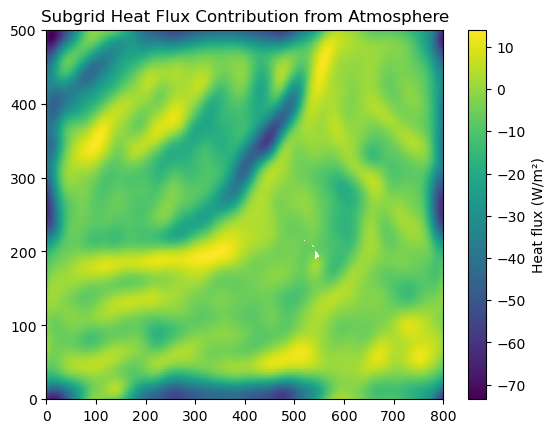

In [75]:
snapshot_HFHR = ds_HFHR_50.isel(time=0)
snapshot_HFLR = ds_HFLR_50_atmosFilt['variable']
snapshot_HFSGS_atmosFilt = snapshot_HFHR - snapshot_HFLR
im = plt.pcolor(snapshot_HFSGS_atmosFilt['__xarray_dataarray_variable__'])
plt.title("Subgrid Heat Flux Contribution from Atmosphere")
plt.colorbar(im, label="Heat flux (W/m²)")
plt.show()

# Case 2: Filter only ocean vars

In [65]:
data_LR = ds_LR.isel(time=0)
data_HR = ds_HR.isel(time=0)

u_rel = data_HR.u_ref - ds_LR_extraFiltVars.u_ocean
v_rel = data_HR.v_ref - ds_LR_extraFiltVars.v_ocean

ql, qh, taux, tauy, evap =  noskin(
        data_LR.surface_temp, # ocean
        data_HR.t_ref,        # atmos
        data_HR.q_ref,        # atmos
        u_rel,   # atmos & ocean
        v_rel,   # atmos & ocean
        slp=data_HR.slp,      # atmos
        algo='ecmwf',
        zt=2,
        zu=10,
)

HF_oceanFilt = qh + ql
HF_oceanFilt

<xarray.DataArray (yt_ocean: 500, xt_ocean: 800)>
dask.array<add, shape=(500, 800), dtype=float32, chunksize=(500, 800), chunktype=numpy.ndarray>
Coordinates:
    time      object 0181-01-01 12:00:00
  * xt_ocean  (xt_ocean) float64 -209.9 -209.8 -209.7 ... -130.3 -130.2 -130.1
  * yt_ocean  (yt_ocean) float64 0.55 0.65 0.75 0.85 ... 44.75 44.82 44.89 44.97
    area_t    (yt_ocean, xt_ocean) float64 1.236e+08 1.236e+08 ... 6.19e+07
    dxt       (yt_ocean, xt_ocean) float64 1.112e+04 1.112e+04 ... 7.867e+03
    dyt       (yt_ocean, xt_ocean) float64 1.112e+04 1.112e+04 ... 7.867e+03
    geolat_t  (yt_ocean, xt_ocean) float32 0.55 0.55 0.55 ... 44.97 44.97 44.97
    geolon_t  (yt_ocean, xt_ocean) float32 -209.9 -209.9 ... -130.1 -130.1
    ht        (yt_ocean, xt_ocean) float32 5.016e+03 5.046e+03 ... 2.56e+03
    kmt       (yt_ocean, xt_ocean) float32 48.0 48.0 48.0 ... 35.0 35.0 36.0
    wet       (yt_ocean, xt_ocean) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0

In [66]:
# Wrap LR HF into a Dataset
data = HF_oceanFilt
da = xr.DataArray(
    data, 
    dims=['yt_ocean', 'xt_ocean'],
    coords={'yt_ocean': data.yt_ocean, 'xt_ocean': data.xt_ocean},
    name='variable'
)
ds = xr.Dataset({'variable': data})

# Filter it to smooth it out
print("Filtering model")
ds_HFLR_50_oceanFilt = filter_inputs_dataset(ds, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')
ds_HFLR_50_oceanFilt

Filtering model


<xarray.Dataset>
Dimensions:   (xt_ocean: 800, yt_ocean: 500)
Coordinates:
    time      object 0181-01-01 12:00:00
  * xt_ocean  (xt_ocean) float64 -209.9 -209.8 -209.7 ... -130.3 -130.2 -130.1
  * yt_ocean  (yt_ocean) float64 0.55 0.65 0.75 0.85 ... 44.75 44.82 44.89 44.97
    area_t    (yt_ocean, xt_ocean) float64 1.236e+08 1.236e+08 ... 6.19e+07
    dxt       (yt_ocean, xt_ocean) float64 1.112e+04 1.112e+04 ... 7.867e+03
    dyt       (yt_ocean, xt_ocean) float64 1.112e+04 1.112e+04 ... 7.867e+03
    geolat_t  (yt_ocean, xt_ocean) float32 0.55 0.55 0.55 ... 44.97 44.97 44.97
    geolon_t  (yt_ocean, xt_ocean) float32 -209.9 -209.9 ... -130.1 -130.1
    ht        (yt_ocean, xt_ocean) float32 5.016e+03 5.046e+03 ... 2.56e+03
    kmt       (yt_ocean, xt_ocean) float32 48.0 48.0 48.0 ... 35.0 35.0 36.0
    wet       (yt_ocean, xt_ocean) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Data variables:
    variable  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

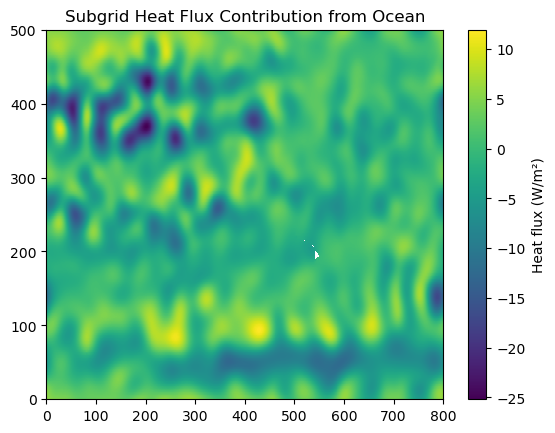

In [76]:
snapshot_HFHR = ds_HFHR_50.isel(time=0)
snapshot_HFLR = ds_HFLR_50_oceanFilt['variable']
snapshot_HFSGS_oceanFilt = snapshot_HFHR - snapshot_HFLR
im = plt.pcolor(snapshot_HFSGS_oceanFilt['__xarray_dataarray_variable__'])
plt.title("Subgrid Heat Flux Contribution from Ocean")
plt.colorbar(im, label="Heat flux (W/m²)")
plt.show()

# Case 3: Filter only velocity vars

In [68]:
data_LR = ds_LR.isel(time=0)
data_HR = ds_HR.isel(time=0)

ql, qh, taux, tauy, evap =  noskin(
        data_HR.surface_temp, # tracer
        data_HR.t_ref,        # tracer
        data_HR.q_ref,        # tracer
        data_LR.u_relative,   # velocity
        data_LR.v_relative,   # velocity
        slp=data_HR.slp,      # tracer
        algo='ecmwf',
        zt=2,
        zu=10,
)

HF_velFilt = qh + ql
HF_velFilt

<xarray.DataArray (yt_ocean: 500, xt_ocean: 800)>
dask.array<add, shape=(500, 800), dtype=float32, chunksize=(500, 800), chunktype=numpy.ndarray>
Coordinates:
    area_t    (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
    dxt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
    dyt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    ht        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    kmt       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    time      object 0181-01-01 12:00:00
    wet       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -209.9 -209.8 -209.7 ... -130.3 -130.2 -130.1
  * yt_ocean  (yt_ocean) float64 0.55 0.65 0.75 0.85 ... 44.75 44.82 44.89 44.97

In [69]:
# Wrap LR HF into a Dataset
data = HF_velFilt
da = xr.DataArray(
    data, 
    dims=['yt_ocean', 'xt_ocean'],
    coords={'yt_ocean': data.yt_ocean, 'xt_ocean': data.xt_ocean},
    name='variable'
)
ds = xr.Dataset({'variable': data})

# Filter it to smooth it out
print("Filtering model")
ds_HFLR_50_velFilt = filter_inputs_dataset(ds, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')
ds_HFLR_50_velFilt

Filtering model


<xarray.Dataset>
Dimensions:   (yt_ocean: 500, xt_ocean: 800)
Coordinates:
    area_t    (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
    dxt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
    dyt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    ht        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    kmt       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    time      object 0181-01-01 12:00:00
    wet       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -209.9 -209.8 -209.7 ... -130.3 -130.2 -130.1
  * yt_ocean  (yt_ocean) float64 0.55 0.65 0.75 0.85 ... 44.75 44.82 44.89 44.97
Data variables:
    variable  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

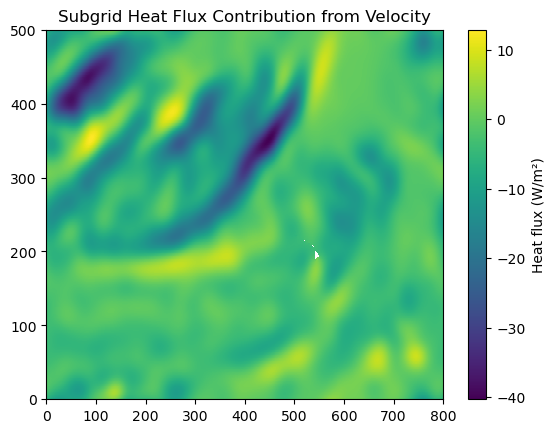

In [77]:
snapshot_HFHR = ds_HFHR_50.isel(time=0)
snapshot_HFLR = ds_HFLR_50_velFilt['variable']
snapshot_HFSGS_velFilt = snapshot_HFHR - snapshot_HFLR
im = plt.pcolor(snapshot_HFSGS_velFilt['__xarray_dataarray_variable__'])
plt.title("Subgrid Heat Flux Contribution from Velocity")
plt.colorbar(im, label="Heat flux (W/m²)")
plt.show()

# Case 4: Filter only tracer vars

In [71]:
data_LR = ds_LR.isel(time=0)
data_HR = ds_HR.isel(time=0)

ql, qh, taux, tauy, evap =  noskin(
        data_LR.surface_temp, # tracer
        data_LR.t_ref,        # tracer
        data_LR.q_ref,        # tracer
        data_HR.u_relative,   # velocity
        data_HR.v_relative,   # velocity
        slp=data_LR.slp,      # tracer
        algo='ecmwf',
        zt=2,
        zu=10,
)

HF_tracerFilt = qh + ql
HF_tracerFilt

<xarray.DataArray (yt_ocean: 500, xt_ocean: 800)>
dask.array<add, shape=(500, 800), dtype=float32, chunksize=(500, 800), chunktype=numpy.ndarray>
Coordinates:
    time      object 0181-01-01 12:00:00
  * xt_ocean  (xt_ocean) float64 -209.9 -209.8 -209.7 ... -130.3 -130.2 -130.1
  * yt_ocean  (yt_ocean) float64 0.55 0.65 0.75 0.85 ... 44.75 44.82 44.89 44.97
    area_t    (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
    dxt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
    dyt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    ht        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    kmt       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    wet       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>

In [72]:
# Wrap LR HF into a Dataset
data = HF_tracerFilt
da = xr.DataArray(
    data, 
    dims=['yt_ocean', 'xt_ocean'],
    coords={'yt_ocean': data.yt_ocean, 'xt_ocean': data.xt_ocean},
    name='variable'
)
ds = xr.Dataset({'variable': data})

# Filter it to smooth it out
print("Filtering model")
ds_HFLR_50_tracerFilt = filter_inputs_dataset(ds, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')
ds_HFLR_50_tracerFilt

Filtering model


<xarray.Dataset>
Dimensions:   (xt_ocean: 800, yt_ocean: 500)
Coordinates:
    time      object 0181-01-01 12:00:00
  * xt_ocean  (xt_ocean) float64 -209.9 -209.8 -209.7 ... -130.3 -130.2 -130.1
  * yt_ocean  (yt_ocean) float64 0.55 0.65 0.75 0.85 ... 44.75 44.82 44.89 44.97
    area_t    (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
    dxt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
    dyt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    ht        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    kmt       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    wet       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(500, 800), meta=np.ndarray>
Data variables:
    variable  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

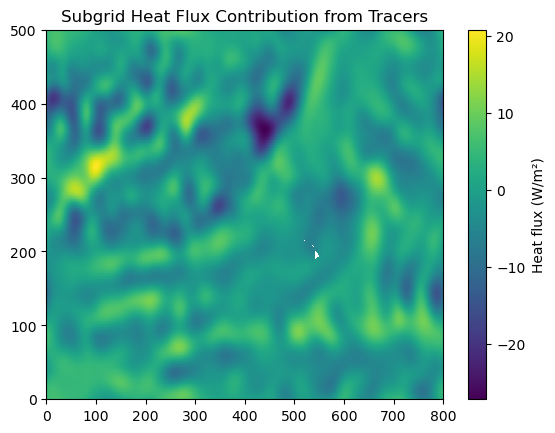

In [78]:
snapshot_HFHR = ds_HFHR_50.isel(time=0)
snapshot_HFLR = ds_HFLR_50_tracerFilt['variable']
snapshot_HFSGS_tracerFilt = snapshot_HFHR - snapshot_HFLR
im = plt.pcolor(snapshot_HFSGS_tracerFilt['__xarray_dataarray_variable__'])
plt.title("Subgrid Heat Flux Contribution from Tracers")
plt.colorbar(im, label="Heat flux (W/m²)")
plt.show()

# All plots together

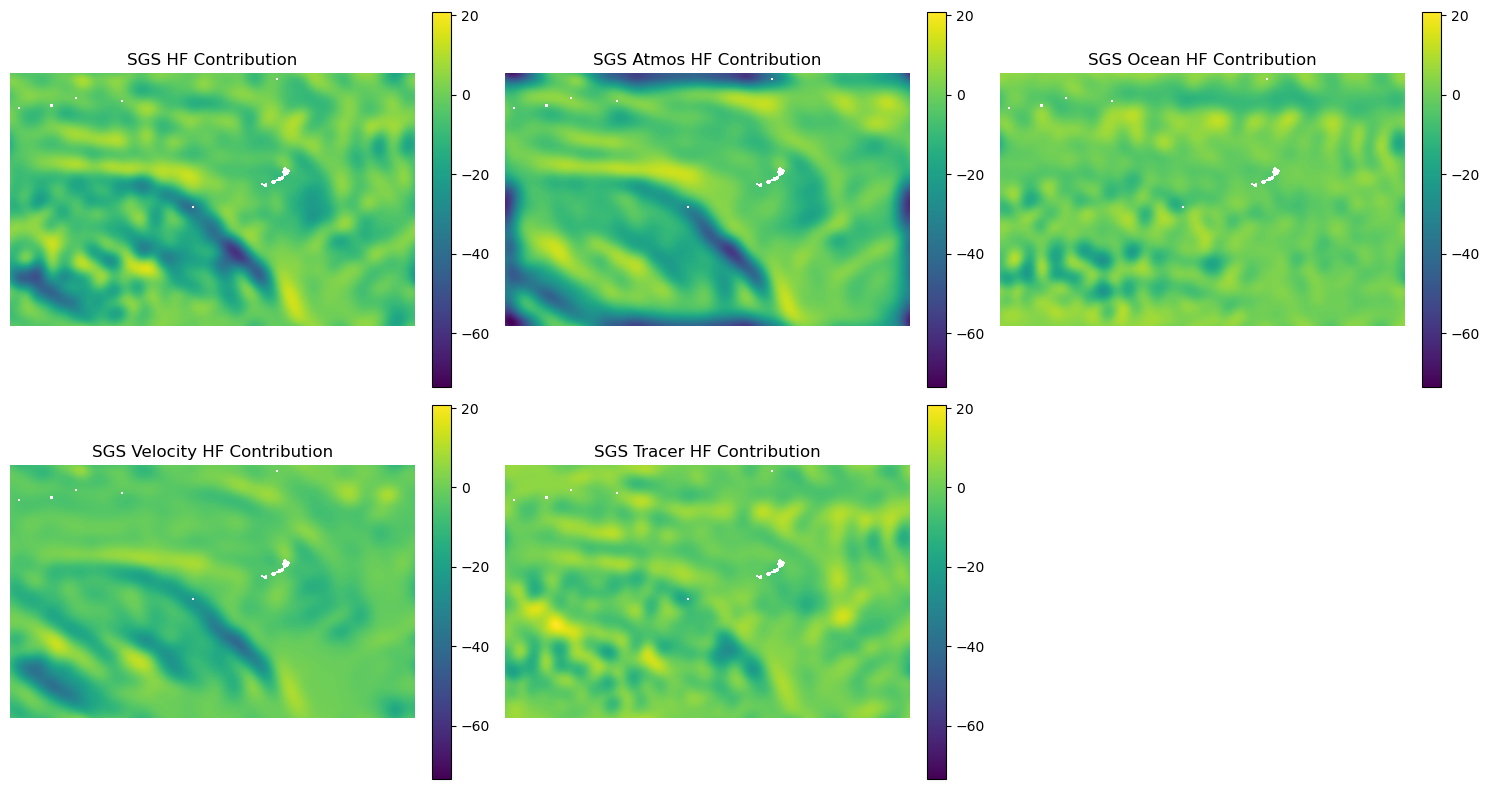

In [80]:
images = [
    snapshot_HFSGS['__xarray_dataarray_variable__'],
    snapshot_HFSGS_atmosFilt['__xarray_dataarray_variable__'],
    snapshot_HFSGS_oceanFilt['__xarray_dataarray_variable__'],
    snapshot_HFSGS_velFilt['__xarray_dataarray_variable__'],
    snapshot_HFSGS_tracerFilt['__xarray_dataarray_variable__']
]

titles = [
    "SGS HF Contribution",
    "SGS Atmos HF Contribution",
    "SGS Ocean HF Contribution",
    "SGS Velocity HF Contribution",
    "SGS Tracer HF Contribution"
]

# Efficient min/max
vmin = min(img.min().compute() for img in images)
vmax = max(img.max().compute() for img in images)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i in range(5):
    im = axes[i].imshow(images[i], vmin=vmin, vmax=vmax)
    axes[i].set_title(titles[i], fontsize=12)
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

axes[5].axis('off')  # Hide the empty plot

plt.tight_layout()
plt.show()
